# Effect of cross validation and permutation

--By Reyan Korel Erben, Qinyuan Fang

We want to examine the effect of cross validation in performance and generalization. 

## Firstly we import the data of one patient from the EEG experiment. 

In [1]:
import mne

# Folder & files containing the data:
data_path = '../PracticalSessions/'
data_file = '817_1_PDDys_ODDBALL_Clean_curated'

filename = data_path + data_file

# We read the EEG epochs:
epochs = mne.read_epochs(filename + '.fif')
epochs = epochs['Standard', 'Novel']
epochs.filter(l_freq = 0.1, h_freq = 20)
epochs.apply_baseline((None, 0))

This filename (../PracticalSessions/817_1_PDDys_ODDBALL_Clean_curated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
Reading ../PracticalSessions/817_1_PDDys_ODDBALL_Clean_curated.fif ...
    Found the data of interest:
        t =    -100.00 ...     500.00 ms
        0 CTF compensation matrices available
189 matching events found
No baseline correction applied
189 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Setting up band-pass filter from 0.1 - 20 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 16501 samples (33.002 sec) selected
filter_length (16501) is longer than the signal (301), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-1-1e4ca4313bcf>:10: RuntimeWarning: This filename (../PracticalSessions/817_1_PDDys_ODDBALL_Clean_curated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(filename + '.fif')
<ipython-input-1-1e4ca4313bcf>:12: RuntimeWarning: filter_length (16501) is longer than the signal (301), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq = 0.1, h_freq = 20)


Applying baseline correction (mode: mean)


<EpochsFIF  |   160 events (all good), -0.1 - 0.5 sec, baseline [None, 0], ~22.2 MB, data loaded,
 'Novel': 30
 'Standard': 130>

## Get data and labels

In [2]:
# and get the data:
data = epochs._data

# and labels:
labels = epochs.events[:,-1]

data.shape
#labels.shape

(160, 60, 301)

## Make pipeline

In [3]:
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import train_test_split

In [4]:
clf_CV = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )

## Cross validation, k = 2 - 10

In [5]:
import numpy as np
all_scores = np.array([0,0])

for ii in range (2,10):
    scores = cross_val_score(clf_CV, data, labels, cv=ii)
    all_scores =  np.append(all_scores,scores.mean())
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))#
print(all_scores)


[0.         0.         0.85       0.84346611 0.86944966 0.83125
 0.83072175 0.84396763 0.84296679 0.85041853]


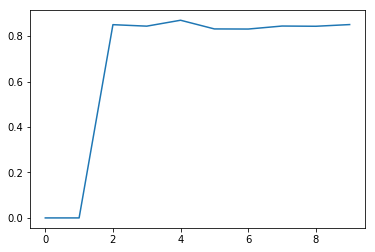

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_scores)

### Best mean score : 0.87, k = 4

In [7]:
best_cv_score = all_scores.max()
print('best cv score: ',best_cv_score)
print('fold : ',np.argmax(all_scores))

best cv score:  0.8694496560350219
fold :  4


## ShuffleSplit

The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.

It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

Here is a visualization of the cross-validation behavior. Note that ShuffleSplit is not affected by classes or groups.


![title](1.png)

## 4-fold cv with shuffle (5 iterations)

In [8]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
scores_shuffled = cross_val_score(clf_CV, data, labels, cv=cv)
#print(scores_shuffled)
score_cv_shuffle5 = scores_shuffled.mean()
print (scores_shuffled, 'mean = ',score_cv_shuffle5)

[0.85  0.875 0.825 0.75  0.85 ] mean =  0.8299999999999998


### mean score = 0.830

## 4-fold cv with shuffle (20 iterations)

In [9]:
cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=0)
scores_shuffled = cross_val_score(clf_CV, data, labels, cv=cv)
#print(scores_shuffled)
score_cv_shuffle20 = scores_shuffled.mean()
print(scores_shuffled, 'mean = ',score_cv_shuffle20)

[0.85  0.875 0.825 0.75  0.85  0.875 0.925 0.825 0.825 0.9   0.8   0.85
 0.875 0.85  0.825 0.9   0.725 0.775 0.875 0.8  ] mean =  0.8387500000000001


### mean score = 0.838

## Normal fit

In [10]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.25, random_state=0)

In [11]:
clf = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )

In [12]:
clf.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x81d379e80>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [13]:
normal_training = clf.score(data_test, labels_test)

## Permutation Test

In [14]:
# Pipelines
pipelines = []
for i in range (25):
    pipeline = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )
    pipelines.append(pipeline)

In [22]:
score_test = []
np.random.seed(seed=0)
for i in range(25):
    labels_train_permute = np.random.permutation(labels_train)
    # np.isclose(labels_train, labels_train_permute)
    pipelines[i].fit(data_train, labels_train_permute)
    score_test.append(pipelines[i].score(data_test, labels_test))
    

In [23]:
print(score_test)

[0.675, 0.8, 0.775, 0.675, 0.6, 0.775, 0.75, 0.65, 0.725, 0.8, 0.675, 0.7, 0.675, 0.8, 0.775, 0.75, 0.775, 0.675, 0.725, 0.725, 0.775, 0.7, 0.75, 0.7, 0.775]


In [25]:
aver_permutest = np.mean(score_test)
print(aver_permutest)

0.728


## Results comparison

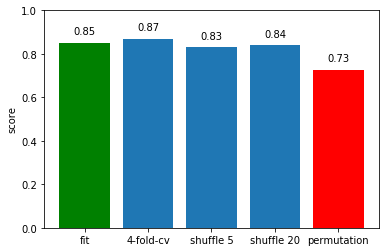

In [26]:
bary = [normal_training, best_cv_score,score_cv_shuffle5,score_cv_shuffle20, aver_permutest]


fig, ax = plt.subplots()

ind = np.arange(1, 6)



b1,b2,b3,b4,b5 = plt.bar(ind, bary)

b5.set_facecolor('r')
b1.set_facecolor('g')
#b3.set_facecolor('b')

ax.set_xticks(ind)
ax.set_xticklabels(['fit','4-fold-cv', 'shuffle 5', 'shuffle 20','permutation'])
ax.set_ylabel('score')
#ax.set_title('')

ax.set_ylim([0, 1])
labels = np.around(bary, decimals=2)

rects = ax.patches;

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height +0.03, label,
           ha='center', va='bottom'
           )


plt.show()

## Conclusion
* By shuffling the data for cv we get lower accuracy, probably because of correlation in data sequence. Info lost.
* Permutation test gives expeced worse result. 